In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as sts 
from getForcingFunctions import getInterpolate, getPrecip
import random

In [ ]:
x = np.linspace(0, np.pi, 10000)

In [ ]:
diurn_cycle_raw = 1290 * np.sin(x)

In [ ]:
day_length = 13

free_time = (24 - day_length)*60/2. # In minutes!
    
free_time = int(free_time)

day_time_shift = np.linspace(free_time, day_length*60 + free_time - 1, day_length*60)
day_time = np.linspace(1, day_length*60, day_length*60)

pre_day = np.zeros(free_time)
post_day = np.zeros(free_time) # i.e., the time from sundown to the end of the day
    
day_avg = 745 * np.sin(np.pi * day_time * (day_length*60)**(-1))

tot_day = np.hstack((pre_day, day_avg, post_day))

plt.plot(day_avg)

len(tot_day)

In [ ]:
vals = sts.pearson3.rvs(-1.4261204198965, loc=1, scale=0.23, size=10000)

plt.hist(vals)

In [ ]:
np.mean(vals), np.amax(vals)

In [ ]:
means = []
diurns = []
maxes = []

randomvalues = sts.pearson3.rvs(-1.4261204198965, loc=1, scale=0.23, size=10000)

goodvals = np.where(randomvalues >= 0)[0]

for i in range(0, 10000):
    goodval_index = np.random.choice(goodvals)
    tmp_diurn = day_avg * randomvalues[goodval_index]
    tmp_mean = np.mean(tmp_diurn)
    tmp_max = np.amax(tmp_diurn)
    means.append(tmp_mean)
    diurns.append(tmp_diurn)
    maxes.append(tmp_max)

In [ ]:
np.amax(diurns), np.mean(diurns), np.amax(means)

In [ ]:
plt.hist(means)

In [ ]:
betas = np.random.beta(6,.9,size=10000)

plt.hist(betas/np.mean(betas),50)

sts.skew(betas/np.mean(betas)), np.mean(betas/np.mean(betas)), np.amax(betas/np.mean(betas))

In [ ]:
rho = 0.8

newweights = np.random.beta(6,2, size=1000)
weights = np.random.beta(6,2, size=1000)

for i in range(1, weights.shape[0]):
    newweights[i] = rho * newweights[i-1] + (1 - rho**2)**(0.5) * np.random.beta(6,2)

means = []

for i in range(0, weights.shape[0]):
    tmp_diurn = newweights[i] * tot_day
    tmp_mean = np.mean(tmp_diurn)
    means.append(tmp_mean)
    
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].hist(newweights, 50)
ax[1].hist(weights, 50)

In [ ]:
plt.hist(maxes)

In [ ]:
test = np.zeros(10000)

for i in range(0, test.shape[0]):
    test[i] = np.random.beta(5, 1.5)

In [ ]:
plt.hist(test)

In [ ]:
### PARAMETER SETUP ###
    
# Some parameters of getRedNoise are fed in from the SGP data, and thus are stored in 
# stats_array.

#rad_anom_norm = 75.
rad_anom_norm = 75.

# they create an envelope of allowable sw radiation for the model.

sw_limit = 1290. # highest allowable daily peak in radiation
sw_average = 800.
sw_min = 150.  # lowest allowable daily peak in radiation

# Set to 0.6 in SLAM, these are correlation coefficients, and must be in (0,1). So for
# consistency:

r_temp = 0.6
r_hum = 0.6
r_rad = 0.7

day_length = 13 # IN HOURS

### CYCLE INITIALIZATION ###

# The basic cycle is formed by taking a unit of free_time, then a unit of day_length,
# then another unit of free_time. This reconstructs the full 24 hour day, and will be 
# a useful structure going forward.

free_time = (24 - day_length)*60/2. # In minutes!

free_time = int(free_time)

# Put the time of the day between, say, 9 and 5 and not from 0 to 8.

day_time_shift = np.linspace(free_time, day_length*60 + free_time - 1, day_length*60)
day_time = np.linspace(1, day_length*60, day_length*60)

# Create radiation profiles as sin waves

day_max = sw_limit * np.sin(np.pi * day_time * (day_length*60)**(-1))
day_avg = sw_average * np.sin(np.pi * day_time * (day_length*60)**(-1))
day_min = sw_min * np.sin(np.pi * day_time * (day_length*60)**(-1))

# make "preday" and "postday," i.e., the time that does not include radiation

pre_day = np.linspace(0, free_time - 1, free_time)
post_day = np.linspace(day_length*60 + free_time, 24*60 - 1, free_time) # i.e., the time from sundown to the end of the day

# make a 'no radiation' array

no_rad = np.zeros(len(pre_day))

# make an array of times that includes the entire day, from midnight to midnight (the next day)

tot_day = np.hstack((pre_day, day_time_shift, post_day))
tot_day_sw_max = np.hstack((no_rad, day_max, no_rad))
tot_day_sw_avg = np.hstack((no_rad, day_avg, no_rad))
tot_day_sw_min = np.hstack((no_rad, day_min, no_rad))

In [ ]:
# now we want to extend the above daily framework to the entire summer!

all_summer_time = 92*24*60 # 92 days in summer, 24 hours in a day, 60 mins in an hour

sw_max_sum = np.tile(tot_day_sw_max, 92) # make 92 days worth of the same radiation
sw_avg_sum = np.tile(tot_day_sw_avg, 92)
sw_min_sum = np.tile(tot_day_sw_min, 92)

In [ ]:
### CREATE RED NOISE FORCING ###

# characteristic time scale of correlation is ~6 hours

num_sixhr = 92 * 4 # number of days * number of 6 hour periods per day

day_vals = np.linspace(0, 1.5*np.pi, 4)
day_trend = np.sin(day_vals)

In [ ]:
rad_summer = np.tile(day_trend, 92)

i = 1
while i < num_sixhr:

    rad_rand = random.gauss(0,1)

    # add day by day variability; correlate the data
    # factor of (1-r^2)^0.5 makes the variance of the temp distribution the same as the
    # random distribution's that we chose temp_rand from, i.e., is one

    rad_summer[i] = r_rad * rad_summer[i-1] + ((1 - r_rad**2)**(0.5)) * rad_rand

    i += 1

rad_summer_min = getInterpolate(rad_summer * rad_anom_norm, all_summer_time)

In [ ]:
### PRECIP AND CLOUD FORCING ###

cf = np.zeros(all_summer_time)
F_solar = np.zeros(all_summer_time)

j = 0
while j < all_summer_time:

    rad_val = sw_avg_sum[j] + rad_summer_min[j]
    max_rad_val = sw_max_sum[j]
    min_rad_val = sw_min_sum[j]

    F_solar[j] = rad_val

    if F_solar[j] < 0:
        F_solar[j] = 0

    if F_solar[j] > max_rad_val:
        F_solar[j] = max_rad_val

    if F_solar[j] < min_rad_val and F_solar[j] > 0:
        F_solar[j] = min_rad_val 

    j += 1
    
# condition rad_summer_min < - rad_anom_norm * 1.25 implies the cloud red noise must be large to gen precip
cloud_atlas = np.where(rad_summer_min < -rad_anom_norm * 1.25) # tells us where clouds are so we can correlate P and F, i.e., make sure 
# there isn't a lot of radiation on rainy days
cloud_count = len(cloud_atlas[0]) # number of cloudy days

stats_array = [0,0,0,0,200,.02,.02]
precip = np.zeros(all_summer_time)
precip_array = getPrecip(stats_array)

k = 0

# make sure precip only happens on days where there are clouds 
while k < len(precip_array):
    rand_cloud_dex = random.randint(0, cloud_count-1)
    precip_dex = cloud_atlas[rand_cloud_dex]
    precip[precip_dex] = precip_array[k]
    k += 1

In [ ]:
test = np.where(rad_summer_min < -rad_anom_norm * 1.25)
testing = len(test[0])
test[0].sort()
cloud_atlas.sort()

In [ ]:
import collections 

if collections.Counter(test[0]) == collections.Counter(cloud_atlas): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 

In [8]:
def getRedNoise(stats_array):
    
    ### PARAMETER SETUP ###
    
    # Some parameters of getRedNoise are fed in from the SGP data, and thus are stored in 
    # stats_array.
    
    #rad_anom_norm = 75.
    rad_anom_norm = stats_array[0]
    
    # they create an envelope of allowable sw radiation for the model.
    
    sw_limit = stats_array[1] # highest allowable daily peak in radiation
    sw_average = stats_array[2] # average daily peak in radiation
    sw_min = stats_array[3]  # lowest allowable daily peak in radiation
    
    #temp_mean = stats_array[4]
    #temp_anom_norm = stats_array[5]
    
    #hum_mean = stats_array[6]
    #hum_anom_mean = stats_array[7]
    
    # Set to 0.6 in SLAM, these are correlation coefficients, and must be in (0,1). So for
    # consistency:
    
    r_temp = 0.6
    r_hum = 0.6
    r_rad = 0.7
    
    day_length = 13 # IN HOURS
    
    ### CYCLE INITIALIZATION ###
    
    # The basic cycle is formed by taking a unit of free_time, then a unit of day_length,
    # then another unit of free_time. This reconstructs the full 24 hour day, and will be 
    # a useful structure going forward.
    
    free_time = (24 - day_length)*60/2. # In minutes!
    
    free_time = int(free_time)
    
    # Put the time of the day between, say, 9 and 5 and not from 0 to 8.
    
    day_time_shift = np.linspace(free_time, day_length*60 + free_time - 1, day_length*60)
    day_time = np.linspace(1, day_length*60, day_length*60)
    
    # Create radiation profiles as sin waves
    
    day_max = sw_limit * np.sin(np.pi * day_time * (day_length*60)**(-1))
    day_avg = sw_average * np.sin(np.pi * day_time * (day_length*60)**(-1))
    day_min = sw_min * np.sin(np.pi * day_time * (day_length*60)**(-1))
    
    # make "preday" and "postday," i.e., the time that does not include radiation
    
    pre_day = np.linspace(0, free_time - 1, free_time)
    post_day = np.linspace(day_length*60 + free_time, 24*60 - 1, free_time) # i.e., the time from sundown to the end of the day
    
    # make a 'no radiation' array
    
    no_rad = np.zeros(len(pre_day))
    
    # make an array of times that includes the entire day, from midnight to midnight (the next day)
    
    tot_day = np.hstack((pre_day, day_time_shift, post_day))
    tot_day_sw_max = np.hstack((no_rad, day_max, no_rad))
    tot_day_sw_avg = np.hstack((no_rad, day_avg, no_rad))
    tot_day_sw_min = np.hstack((no_rad, day_min, no_rad))
    
    # now we want to extend the above daily framework to the entire summer!
    
    all_summer_time = 92*24*60 # 92 days in summer, 24 hours in a day, 60 mins in an hour
    
    sw_max_sum = np.tile(tot_day_sw_max, 92) # make 92 days worth of the same radiation
    sw_avg_sum = np.tile(tot_day_sw_avg, 92)
    sw_min_sum = np.tile(tot_day_sw_min, 92)
    
    ### CREATE RED NOISE FORCING ###
    
    # characteristic time scale of correlation is ~6 hours
    
    num_sixhr = 92 * 4 # number of days * number of 6 hour periods per day
    
    day_vals = np.linspace(0, 1.5*np.pi, 4)
    day_trend = np.sin(day_vals)
    
    #temp_summer = np.tile(day_trend, 92) # makes an array with 92 copies of temp_day back to back
    #hum_summer = np.tile(day_trend, 92) 
    
    rad_summer = np.tile(day_trend, 92)
    
    i = 1
    while i < num_sixhr:
        
        #temp_rand = random.gauss(0,1) # sample a gaussian distribution with mean = 0 and std = 1
        #hum_rand = random.gauss(0,1) # UNCORRELATED TEMP AND HUM 
        
        rad_rand = random.gauss(0,1)
        
        # add day by day variability; correlate the data
        # factor of (1-r^2)^0.5 makes the variance of the temp distribution the same as the
        # random distribution's that we chose temp_rand from, i.e., is one
        
        #temp_summer[i] = r_temp * temp_summer[i-1] + ((1 - r_temp**2)**(0.5)) * temp_rand
        #hum_summer[i] = r_hum * hum_summer[i-1] + ((1 - r_hum**2)**(0.5)) * hum_rand
        
        rad_summer[i] = r_rad * rad_summer[i-1] + ((1 - r_rad**2)**(0.5)) * rad_rand
        
        i += 1
    
    #temp_summer_min = getInterpolate(temp_mean + temp_summer * temp_anom_norm, all_summer_time)
    #hum_summer_min = getInterpolate(hum_mean + hum_summer * hum_anom_norm, all_summer_time)
    
    rad_summer_min = getInterpolate(rad_summer * rad_anom_norm, all_summer_time)
    
    # THIS FINISHES TEMPERATURE AND HUMIDITY
    
    ### PRECIP AND CLOUD FORCING ###
    
    cf = np.zeros(all_summer_time)
    F_solar = np.zeros(all_summer_time)
    
    cloud_count = 0
    cloud_atlas = [] # tells us where clouds are so we can correlate P and F, i.e., make sure 
    # there isn't a lot of radiation on rainy days
    
    j = 0
    while j < all_summer_time:
        
        rad_val = sw_avg_sum[j] + rad_summer_min[j]
        max_rad_val = sw_max_sum[j]
        min_rad_val = sw_min_sum[j]
        
        # cloud red noise has to be large for the cloud atlas to generate precip
        if rad_summer_min[j] < -rad_anom_norm * 1.1: 
            cloud_atlas.append(j)
            cloud_count += 1
            
        F_solar[j] = rad_val
        
        if F_solar[j] < 0:
            F_solar[j] = 0
        
        if F_solar[j] > max_rad_val:
            F_solar[j] = max_rad_val
            
        if F_solar[j] < min_rad_val and F_solar[j] > 0:
            F_solar[j] = min_rad_val 
        
        """
        cf[j] = - rad_summer_min[j] * (2 * sw_limit)**(-1)
        
        if cf[j] > 1:
            cf[j] = 1
        
        if cf[j] < 0:
            cf[j] = 0
        """
        
        j += 1
        
    precip = np.zeros(all_summer_time)
    precip_array = getPrecip(stats_array)
    
    # make sure that the number of clouds per minute outnumbers the number of minutes it is raining
    i = 0
    j = 1
    while i < j:
        if cloud_count > len(precip_array) * 60:
            j = -1
            
        else:
            precip_array = getPrecip(stats_array)
            
    ### 
    # define array of EVENT indices
    ###
    
    min_rate = 60
    
    hours = int((cloud_count - cloud_count%min_rate)/float(min_rate)) # needs to be a multiple of 60 for our purposes 
    cloud_atlas_trimmed = np.asarray(cloud_atlas)[0:hours*min_rate]
    event_arrays = np.split(cloud_atlas_trimmed, hours)
    event_count = len(event_arrays)
    
    k = 0
    # make sure precip only happens on days where there are clouds 
    while k < len(precip_array):
        rand_event_dex = random.randint(0, event_count-1)
        event_start_index = np.amin(event_arrays[rand_event_dex])
        event_end_index = np.amax(event_arrays[rand_event_dex])
        precip[event_start_index:event_end_index] = precip_array[k]/float(min_rate)
        k += 1
    
    return F_solar, precip, cloud_atlas, cloud_count, precip_array

In [9]:
def getInterpolate(array, new_length):
    old_time = np.linspace(0, new_length - 1, len(array))
    new_time = np.linspace(0, new_length - 1, new_length)
    new_array = np.interp(new_time, old_time, array)
    
    return new_array

In [10]:
import numpy as np

def getPrecip(stats_array):
    
    # Take the relevant statistics from the SGP data to tune our precip
    # events
    
    cum_precip = stats_array[4] # average total rainfall in a summer
    std_precip = stats_array[5]
    
    indiv_event_mean = stats_array[6]
    
    # Generate a normal distribution for the cumulative rain?
    
    cumulative_rain = np.random.gamma(cum_precip, scale=1.0) # sample a dist for tot rain
    #print(cumulative_rain)
    
    precip_events = []

    # Confused about this statement. What does it mean for the sum of the 
    # precipitation events to be less than the *distribution* of 
    # cumulative rain events?
    
    while cumulative_rain > np.sum(precip_events):
        tmp_precip = np.random.gamma(indiv_event_mean, scale=.6) # why from a gamma dist?
        if tmp_precip < 0.2:
            continue 
        
        elif tmp_precip > 2.5:
            continue 
            
        else:
            precip_events.append(tmp_precip)
    
    #print(precip_events)
    
    return precip_events

In [11]:
array = [300, 1090, 900, 140, 200, 2 * 10**(-2), .6]

rad, prec, atlas, count, events = getRedNoise(array)

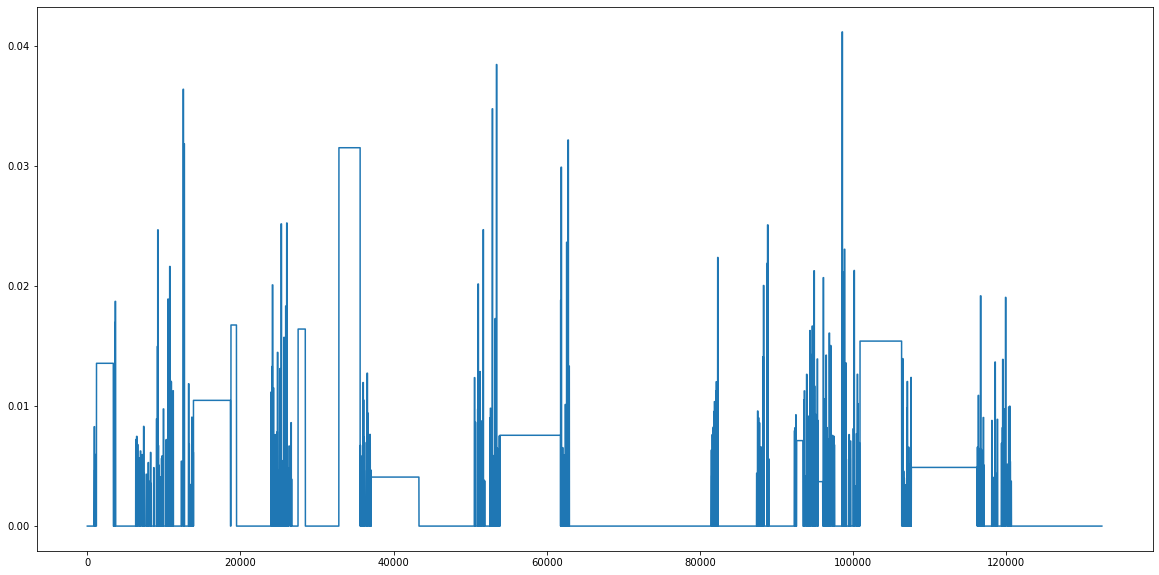

In [12]:
fig, ax = plt.subplots(1, figsize=(20,10))

ax.plot(prec)

In [ ]:
day = np.split(prec, 92)
fig, ax = plt.subplots(10, figsize=(20,10))
for i in range(0, 10):
    ax[i].plot(day[i+80])

In [ ]:
test = np.zeros(count)
for i in range(0,count-1):
    if atlas[i+1] - atlas[i] == 1:
        test[i] = atlas[i]
        
    else: 
        continue
days = int(test.shape[0]/60)
int((count-count%60)/60)

hours =int((count-count%60)/60)

actual_atlas = np.asarray(atlas)[0:hours*60]
event_ind = np.split(actual_atlas, hours)
start = np.amin(event_ind[0])
end = np.amax(event_ind[0])
start, end

In [ ]:
plt.hist(np.asarray(events), 20)
plt.xlim(0.2, 4)
len(events)

In [ ]:
np.where(np.asarray(events) > 2*0.762)